In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [ ]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.2, 0.2, size=nsamples)
    x_data = np.random.uniform(-0.98, 0.98, size=(nsamples, dim_x, dim_y)) - means[...,None,None]
    np.clip(x_data, -0.95, 0.95, out=x_data)
    return x_data


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.15, 0.15, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.3, 0.6, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return (((y1 - y2)*scale) ** 2).sum() / y1.data.nelement() 

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [9]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, device=device)
    return x_data, y_data

In [41]:
%%time
x_data, y_data = data_generator(nsamples=16, 
                                dim_x=96, 
                                init_steps=1, 
                                delta_sim_steps = 2000,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

CPU times: user 309 ms, sys: 4.68 ms, total: 313 ms
Wall time: 318 ms


# Set Device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [43]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 96, 96))

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
#                        in_channels=1, 
#                        out_channels=1, 
#                        init_features=32, 
#                        pretrained=False).double().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             288
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,216
       BatchNorm2d-5           [-1, 32, 96, 96]              64
              ReLU-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,432
       BatchNorm2d-9           [-1, 64, 48, 48]             128
             ReLU-10           [-1, 64, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          36,864
      BatchNorm2d-12           [-1, 64, 48, 48]             128
             ReLU-13           [-1, 64, 48, 48]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [44]:
# transformer_x = lambda x: x[None]
# transformer_y = lambda x: x[None]
from pymks.bases import LegendreBasis

n_states = 3
domain = (-1.01, 1.01)
basis = LegendreBasis(n_states, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_y = lambda x: x[None]



dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 3, 96, 96]) torch.Size([1, 1, 96, 96])


In [45]:
model = UNet(in_channels=n_states, 
             out_channels=1, 
             init_features=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.3139, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [11]:
## Process Parameters
dim_x=96
init_steps=10
delta_sim_steps = 3000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296


trn_size = 10
n_samples_trn = 1024*trn_size
n_samples_val = 256
n_samples_prd = 256

init_features=32

args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [12]:
%%time
# x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
#                               dim_x=dim_x, 
#                                 init_steps=init_steps, 
#                                 delta_sim_steps = delta_sim_steps,
#                                 dx = dx, 
#                                 dt = dt,
#                                 gamma=gamma, 
#                                 seed =seed_trn,
#                                 device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 6.72 s, sys: 3.82 s, total: 10.5 s
Wall time: 9.37 s


In [14]:
# draw_im(x_trn[0], "training input")

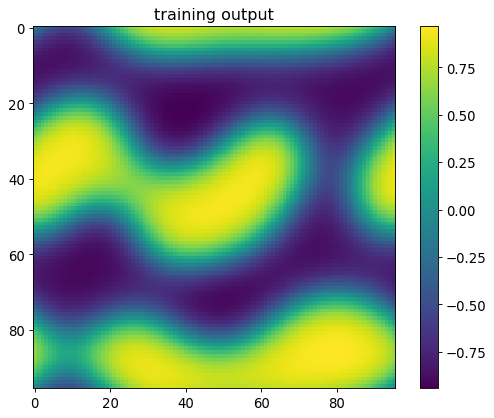

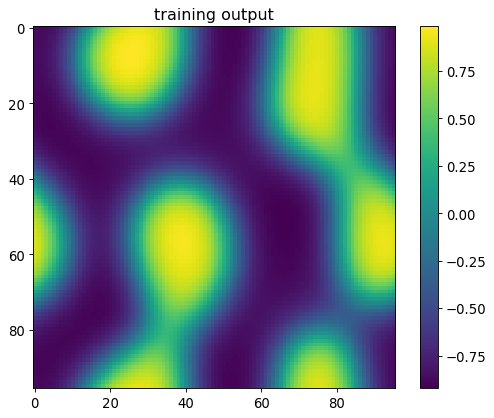

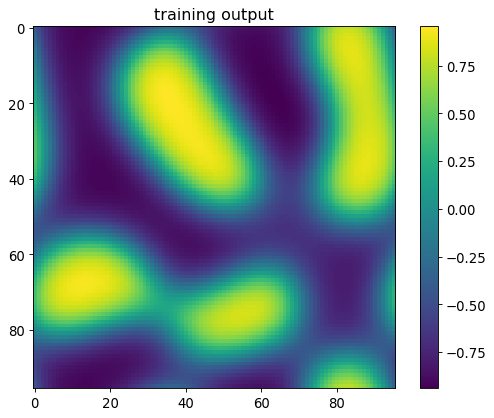

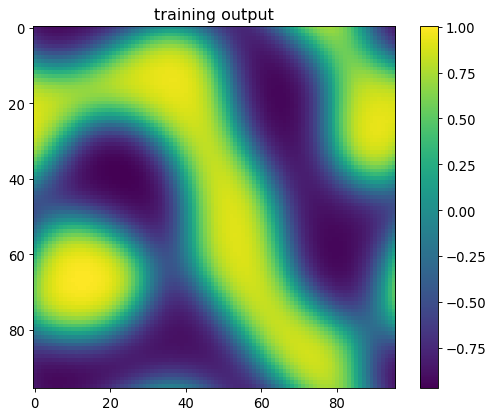

In [54]:
draw_im(y_trn[0], "training output")
draw_im(y_trn[5], "training output")
draw_im(y_trn[-5], "training output")
draw_im(y_trn[-1], "training output")

In [65]:
%time
# trn_seed = 9237919
# # trn_seed = 1381693
# # trn_seed = 38496502

# x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
#                               dim_x=dim_x, 
#                                 init_steps=init_steps, 
#                                 delta_sim_steps = delta_sim_steps,
#                                 dx = dx, 
#                                 dt = dt,
#                                 gamma=gamma, 
#                                 seed =seed_trn,
#                                 device = device)

In [15]:
# from pymks.bases import LegendreBasis

n_states = 1
# domain = (-1.01, 1.01)
# basis = LegendreBasis(n_states, domain)
# transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

# trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 8

# trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


# total_step = len(trn_loader)
# print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of validation steps: 32
No. of prediction steps: 32


In [16]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [17]:
run_id = dt_string + "_run_leg_{}_data_{}_large".format(n_states, trn_size)
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)


tag = folder+"unet_"
print(tag)

14-04-2020-22-37_run_leg_1_data_10_large
out/unet/ch_unet_id_14-04-2020-22-37_run_leg_1_data_10_large/
out/unet/ch_unet_id_14-04-2020-22-37_run_leg_1_data_10_large/unet_


In [18]:
if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)

In [20]:
from chnet.unet import UNet
model = UNet(in_channels=n_states, 
             out_channels=1, 
             init_features=init_features).double().to(device)

In [21]:
num_epochs = 50
criterion = mse_loss(scale=100)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []
seed_list = []

In [37]:
num_epochs = 300
learning_rate = 1e-7

In [ ]:
# Loss and optimizer
for epoch in range(151, num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))
    
    if epoch % 5 == 0:
        s = np.random.randint(0, 100000, 1)[0]
        seed_list.append(s)
        x_trn, y_trn = data_generator(nsamples=1024*trn_size, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =s,
                                device = device)
        
        trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
        trn_loader = DataLoader(trn_dataset, batch_size=8, shuffle=True, num_workers=2)
        total_step = len(trn_loader)
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 128 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 
torch.save(trn_losses, tag+"trn_loss.pt")
torch.save(val_losses, tag+"val_loss.pt")

Epoch [152/300], Step [1/1280], Training Loss: 5.97656470616, Validation Loss: 5.12797409545
Epoch [152/300], Step [129/1280], Training Loss: 5.76931101698, Validation Loss: 5.20135473394
Epoch [152/300], Step [257/1280], Training Loss: 5.73467684851, Validation Loss: 5.12790464901
Epoch [152/300], Step [385/1280], Training Loss: 5.82138285691, Validation Loss: 5.13450714701
Epoch [152/300], Step [513/1280], Training Loss: 5.83823985328, Validation Loss: 4.80155226639
Epoch [152/300], Step [641/1280], Training Loss: 6.04857254919, Validation Loss: 5.71771601653
Epoch [152/300], Step [769/1280], Training Loss: 5.92097807041, Validation Loss: 5.83446503809
Epoch [152/300], Step [897/1280], Training Loss: 5.88382723766, Validation Loss: 6.27193065693
Epoch [152/300], Step [1025/1280], Training Loss: 5.93976705291, Validation Loss: 5.46975175357
Epoch [152/300], Step [1153/1280], Training Loss: 5.70305736518, Validation Loss: 6.01211048335



Epoch [153/300], Step [1/1280], Training Loss: 5.94294549625, Validation Loss: 4.53428316419
Epoch [153/300], Step [129/1280], Training Loss: 5.54859078917, Validation Loss: 4.48386716533
Epoch [153/300], Step [257/1280], Training Loss: 5.52964513117, Validation Loss: 4.94239432765
Epoch [153/300], Step [385/1280], Training Loss: 5.55509598290, Validation Loss: 6.20797571449
Epoch [153/300], Step [513/1280], Training Loss: 5.46954296432, Validation Loss: 4.20170096453
Epoch [153/300], Step [641/1280], Training Loss: 5.83189100880, Validation Loss: 5.33617401981
Epoch [153/300], Step [769/1280], Training Loss: 5.60367997258, Validation Loss: 4.91507779466
Epoch [153/300], Step [897/1280], Training Loss: 5.55776503997, Validation Loss: 5.04515318806
Epoch [153/300], Step [1025/1280], Training Loss: 6.11608568228, Validation Loss: 5.60916747106
Epoch [153/300], Step [1153/1280], Training Loss: 5.70100548879, Validation Loss: 4.89083308259



Epoch [154/300], Step [1/1280], Training Loss: 5.67524723709, Validation Loss: 4.84061589116
Epoch [154/300], Step [129/1280], Training Loss: 5.55718953029, Validation Loss: 5.40106178643
Epoch [154/300], Step [257/1280], Training Loss: 5.51471733205, Validation Loss: 4.59699983783
Epoch [154/300], Step [385/1280], Training Loss: 5.74559954714, Validation Loss: 4.66298649516
Epoch [154/300], Step [513/1280], Training Loss: 5.52380562911, Validation Loss: 5.50732301383
Epoch [154/300], Step [641/1280], Training Loss: 5.59241271487, Validation Loss: 5.33738584939
Epoch [154/300], Step [769/1280], Training Loss: 5.33396473262, Validation Loss: 4.62640258361
Epoch [154/300], Step [897/1280], Training Loss: 5.63703955596, Validation Loss: 5.71739830006
Epoch [154/300], Step [1025/1280], Training Loss: 5.90739469822, Validation Loss: 5.09494899542
Epoch [154/300], Step [1153/1280], Training Loss: 5.43604292874, Validation Loss: 5.12978722929



Epoch [155/300], Step [1/1280], Training Loss: 5.74506675775, Validation Loss: 5.37418980592
Epoch [155/300], Step [129/1280], Training Loss: 5.36132784128, Validation Loss: 5.21453304451
Epoch [155/300], Step [257/1280], Training Loss: 5.15718572273, Validation Loss: 4.78015023308
Epoch [155/300], Step [385/1280], Training Loss: 5.19353843482, Validation Loss: 4.74057600563
Epoch [155/300], Step [513/1280], Training Loss: 5.59876512659, Validation Loss: 5.31373411528
Epoch [155/300], Step [641/1280], Training Loss: 5.22914764165, Validation Loss: 4.87915147066
Epoch [155/300], Step [769/1280], Training Loss: 5.41090186823, Validation Loss: 4.86955924990
Epoch [155/300], Step [897/1280], Training Loss: 5.45953738532, Validation Loss: 4.69730446967
Epoch [155/300], Step [1025/1280], Training Loss: 5.32953801423, Validation Loss: 5.50496082884
Epoch [155/300], Step [1153/1280], Training Loss: 5.49102053576, Validation Loss: 5.40473088295



Epoch [156/300], Step [1/1280], Training Loss: 5.53731489275, Validation Loss: 6.46663339098
Epoch [156/300], Step [129/1280], Training Loss: 7.60892933270, Validation Loss: 6.88667696758
Epoch [156/300], Step [257/1280], Training Loss: 7.02225891260, Validation Loss: 6.68153435247
Epoch [156/300], Step [385/1280], Training Loss: 7.15332490182, Validation Loss: 7.28500756670
Epoch [156/300], Step [513/1280], Training Loss: 6.92094725476, Validation Loss: 6.87467698674
Epoch [156/300], Step [641/1280], Training Loss: 6.96927774110, Validation Loss: 7.24063352634
Epoch [156/300], Step [769/1280], Training Loss: 6.66679053537, Validation Loss: 6.15280269618
Epoch [156/300], Step [897/1280], Training Loss: 7.06346640138, Validation Loss: 5.56265338987
Epoch [156/300], Step [1025/1280], Training Loss: 6.80375174065, Validation Loss: 7.17944894365
Epoch [156/300], Step [1153/1280], Training Loss: 7.18097435368, Validation Loss: 6.98804992304



Epoch [157/300], Step [1/1280], Training Loss: 6.86592210284, Validation Loss: 5.83037002323
Epoch [157/300], Step [129/1280], Training Loss: 6.59411128432, Validation Loss: 6.92385738512
Epoch [157/300], Step [257/1280], Training Loss: 6.65294862665, Validation Loss: 5.70664070042
Epoch [157/300], Step [385/1280], Training Loss: 6.59379880696, Validation Loss: 5.98097010343
Epoch [157/300], Step [513/1280], Training Loss: 6.41348973478, Validation Loss: 6.16369127937
Epoch [157/300], Step [641/1280], Training Loss: 6.81441991689, Validation Loss: 6.36233874694
Epoch [157/300], Step [769/1280], Training Loss: 6.42218028530, Validation Loss: 6.21818007076
Epoch [157/300], Step [897/1280], Training Loss: 6.36718855518, Validation Loss: 5.48732171440
Epoch [157/300], Step [1025/1280], Training Loss: 6.37382528622, Validation Loss: 5.97210609712
Epoch [157/300], Step [1153/1280], Training Loss: 6.47178156201, Validation Loss: 6.04223125612



Epoch [158/300], Step [1/1280], Training Loss: 6.49501069530, Validation Loss: 5.82757098163
Epoch [158/300], Step [129/1280], Training Loss: 6.20204849574, Validation Loss: 6.32735359674
Epoch [158/300], Step [257/1280], Training Loss: 6.08896888129, Validation Loss: 5.57050716722
Epoch [158/300], Step [385/1280], Training Loss: 5.89616845944, Validation Loss: 5.82913768568
Epoch [158/300], Step [513/1280], Training Loss: 6.13094936752, Validation Loss: 5.82987333757
Epoch [158/300], Step [641/1280], Training Loss: 5.97156052151, Validation Loss: 5.87962878225
Epoch [158/300], Step [769/1280], Training Loss: 6.27988864163, Validation Loss: 5.73789523846
Epoch [158/300], Step [897/1280], Training Loss: 6.10140328874, Validation Loss: 6.34973465418
Epoch [158/300], Step [1025/1280], Training Loss: 6.24037347046, Validation Loss: 5.97316153990
Epoch [158/300], Step [1153/1280], Training Loss: 6.23135800701, Validation Loss: 5.55993432367



Epoch [159/300], Step [1/1280], Training Loss: 6.32449628093, Validation Loss: 5.54868610929
Epoch [159/300], Step [129/1280], Training Loss: 5.76572420502, Validation Loss: 5.71513481540
Epoch [159/300], Step [257/1280], Training Loss: 5.89097046285, Validation Loss: 5.37272697337
Epoch [159/300], Step [385/1280], Training Loss: 5.86243236821, Validation Loss: 5.43265882667
Epoch [159/300], Step [513/1280], Training Loss: 5.91903924646, Validation Loss: 5.05323009464
Epoch [159/300], Step [641/1280], Training Loss: 6.02979747617, Validation Loss: 5.83095797922
Epoch [159/300], Step [769/1280], Training Loss: 6.27004645652, Validation Loss: 5.77266520277
Epoch [159/300], Step [897/1280], Training Loss: 6.53645929861, Validation Loss: 5.96112519856
Epoch [159/300], Step [1025/1280], Training Loss: 6.20749058366, Validation Loss: 6.10084355770
Epoch [159/300], Step [1153/1280], Training Loss: 6.00603595520, Validation Loss: 5.17998106629



Epoch [160/300], Step [1/1280], Training Loss: 5.70844843694, Validation Loss: 5.01983529613
Epoch [160/300], Step [129/1280], Training Loss: 5.73471386021, Validation Loss: 5.46177266520
Epoch [160/300], Step [257/1280], Training Loss: 5.81350293053, Validation Loss: 5.92367941883
Epoch [160/300], Step [385/1280], Training Loss: 5.67710449932, Validation Loss: 5.43045421552
Epoch [160/300], Step [513/1280], Training Loss: 5.54834643425, Validation Loss: 4.49817395962
Epoch [160/300], Step [641/1280], Training Loss: 5.84810568547, Validation Loss: 5.92920324142
Epoch [160/300], Step [769/1280], Training Loss: 5.79799127036, Validation Loss: 5.19225887714
Epoch [160/300], Step [897/1280], Training Loss: 5.99899560796, Validation Loss: 5.25589175305
Epoch [160/300], Step [1025/1280], Training Loss: 5.87193257952, Validation Loss: 5.23620950771
Epoch [160/300], Step [1153/1280], Training Loss: 5.77413597580, Validation Loss: 5.23214532142



Epoch [161/300], Step [1/1280], Training Loss: 6.07203302251, Validation Loss: 7.10246989845
Epoch [161/300], Step [129/1280], Training Loss: 6.88139910794, Validation Loss: 6.23031118106
Epoch [161/300], Step [257/1280], Training Loss: 7.02609363555, Validation Loss: 6.08008781043
Epoch [161/300], Step [385/1280], Training Loss: 7.13532427473, Validation Loss: 7.53593956294
Epoch [161/300], Step [513/1280], Training Loss: 6.78064406672, Validation Loss: 7.02491244199
Epoch [161/300], Step [641/1280], Training Loss: 6.97903200906, Validation Loss: 6.83653073147
Epoch [161/300], Step [769/1280], Training Loss: 6.60874536045, Validation Loss: 6.17405660420
Epoch [161/300], Step [897/1280], Training Loss: 6.84929191424, Validation Loss: 7.20981964719
Epoch [161/300], Step [1025/1280], Training Loss: 7.02091489604, Validation Loss: 6.54760051935
Epoch [161/300], Step [1153/1280], Training Loss: 6.95504177454, Validation Loss: 6.31608132495



Epoch [162/300], Step [1/1280], Training Loss: 6.88577837498, Validation Loss: 6.00163135447
Epoch [162/300], Step [129/1280], Training Loss: 6.35906318072, Validation Loss: 6.18676412130
Epoch [162/300], Step [257/1280], Training Loss: 6.29982099342, Validation Loss: 4.73225635004
Epoch [162/300], Step [385/1280], Training Loss: 6.35195817000, Validation Loss: 6.85944417688
Epoch [162/300], Step [513/1280], Training Loss: 6.39081203963, Validation Loss: 6.65141561376
Epoch [162/300], Step [641/1280], Training Loss: 6.45015624234, Validation Loss: 6.17470506983
Epoch [162/300], Step [769/1280], Training Loss: 6.36400021381, Validation Loss: 6.28508729014
Epoch [162/300], Step [897/1280], Training Loss: 6.43243225018, Validation Loss: 5.85469897719
Epoch [162/300], Step [1025/1280], Training Loss: 6.58236877182, Validation Loss: 5.82509488737
Epoch [162/300], Step [1153/1280], Training Loss: 6.40282490953, Validation Loss: 6.49622162845



Epoch [163/300], Step [1/1280], Training Loss: 6.45741146279, Validation Loss: 5.42685025217
Epoch [163/300], Step [129/1280], Training Loss: 6.20597476359, Validation Loss: 5.35793745599
Epoch [163/300], Step [257/1280], Training Loss: 5.64092846865, Validation Loss: 5.65171792014
Epoch [163/300], Step [385/1280], Training Loss: 6.00041239946, Validation Loss: 6.09516129422
Epoch [163/300], Step [513/1280], Training Loss: 6.17426743775, Validation Loss: 5.82157964740
Epoch [163/300], Step [641/1280], Training Loss: 6.33226127977, Validation Loss: 6.49524610129
Epoch [163/300], Step [769/1280], Training Loss: 6.22421339565, Validation Loss: 6.47490049262
Epoch [163/300], Step [897/1280], Training Loss: 6.05471832814, Validation Loss: 5.91764749469
Epoch [163/300], Step [1025/1280], Training Loss: 6.33168378537, Validation Loss: 5.27070896974
Epoch [163/300], Step [1153/1280], Training Loss: 6.07546081252, Validation Loss: 5.51307545245



Epoch [164/300], Step [1/1280], Training Loss: 6.02196544799, Validation Loss: 4.96806383093
Epoch [164/300], Step [129/1280], Training Loss: 5.73282758379, Validation Loss: 5.45580820734
Epoch [164/300], Step [257/1280], Training Loss: 5.73523463063, Validation Loss: 5.00610784220
Epoch [164/300], Step [385/1280], Training Loss: 6.01038987445, Validation Loss: 5.60132668985
Epoch [164/300], Step [513/1280], Training Loss: 5.81906289228, Validation Loss: 4.76645358839
Epoch [164/300], Step [641/1280], Training Loss: 5.96126543110, Validation Loss: 5.63481582176
Epoch [164/300], Step [769/1280], Training Loss: 6.01676593806, Validation Loss: 5.65662335051
Epoch [164/300], Step [897/1280], Training Loss: 5.98873031814, Validation Loss: 5.15596709036
Epoch [164/300], Step [1025/1280], Training Loss: 6.11556376339, Validation Loss: 6.18065789893
Epoch [164/300], Step [1153/1280], Training Loss: 6.14735154623, Validation Loss: 5.75117477075



Epoch [165/300], Step [1/1280], Training Loss: 5.89235494162, Validation Loss: 5.29365451694
Epoch [165/300], Step [129/1280], Training Loss: 5.83335482215, Validation Loss: 5.65132457177
Epoch [165/300], Step [257/1280], Training Loss: 6.04411720049, Validation Loss: 4.70816997902
Epoch [165/300], Step [385/1280], Training Loss: 5.87360162104, Validation Loss: 5.55869681433
Epoch [165/300], Step [513/1280], Training Loss: 5.75624135170, Validation Loss: 5.11726024590
Epoch [165/300], Step [641/1280], Training Loss: 6.00932989533, Validation Loss: 5.56326182956
Epoch [165/300], Step [769/1280], Training Loss: 6.05949928568, Validation Loss: 5.99502836237
Epoch [165/300], Step [897/1280], Training Loss: 5.69845001888, Validation Loss: 4.91982431278
Epoch [165/300], Step [1025/1280], Training Loss: 5.76083604488, Validation Loss: 5.14451585354
Epoch [165/300], Step [1153/1280], Training Loss: 5.89484933151, Validation Loss: 5.59405582414



Epoch [166/300], Step [1/1280], Training Loss: 5.56871926627, Validation Loss: 5.83833952419
Epoch [166/300], Step [129/1280], Training Loss: 7.03962084532, Validation Loss: 6.45655340746
Epoch [166/300], Step [257/1280], Training Loss: 6.63614082603, Validation Loss: 6.45035993036
Epoch [166/300], Step [385/1280], Training Loss: 6.83666735044, Validation Loss: 6.25340805586
Epoch [166/300], Step [513/1280], Training Loss: 6.71204690064, Validation Loss: 7.24497398478
Epoch [166/300], Step [641/1280], Training Loss: 6.85481191436, Validation Loss: 6.55905828347
Epoch [166/300], Step [769/1280], Training Loss: 6.85336108447, Validation Loss: 6.86759912772
Epoch [166/300], Step [897/1280], Training Loss: 6.52408063155, Validation Loss: 6.86667561796
Epoch [166/300], Step [1025/1280], Training Loss: 6.84805927434, Validation Loss: 5.95601411358
Epoch [166/300], Step [1153/1280], Training Loss: 7.07346513678, Validation Loss: 6.76831252358



Epoch [167/300], Step [1/1280], Training Loss: 6.59688929907, Validation Loss: 5.52406795653
Epoch [167/300], Step [129/1280], Training Loss: 6.41694493506, Validation Loss: 6.84756111443
Epoch [167/300], Step [257/1280], Training Loss: 6.04944981383, Validation Loss: 5.69160890887
Epoch [167/300], Step [385/1280], Training Loss: 5.98311811314, Validation Loss: 5.36028032108
Epoch [167/300], Step [513/1280], Training Loss: 5.97353773163, Validation Loss: 5.26466813283
Epoch [167/300], Step [641/1280], Training Loss: 6.41582341013, Validation Loss: 5.56016032606
Epoch [167/300], Step [769/1280], Training Loss: 6.29452577612, Validation Loss: 6.40433430073
Epoch [167/300], Step [897/1280], Training Loss: 6.34858751557, Validation Loss: 4.72750805188
Epoch [167/300], Step [1025/1280], Training Loss: 6.50405878788, Validation Loss: 5.72812812554
Epoch [167/300], Step [1153/1280], Training Loss: 6.29435365989, Validation Loss: 5.39744855182



Epoch [168/300], Step [1/1280], Training Loss: 6.30908258132, Validation Loss: 5.69780674766
Epoch [168/300], Step [129/1280], Training Loss: 5.94425901744, Validation Loss: 5.40183198977
Epoch [168/300], Step [257/1280], Training Loss: 6.03578647858, Validation Loss: 5.31790220034
Epoch [168/300], Step [385/1280], Training Loss: 5.99903019223, Validation Loss: 5.25768026160
Epoch [168/300], Step [513/1280], Training Loss: 6.13029531686, Validation Loss: 5.36707042657
Epoch [168/300], Step [641/1280], Training Loss: 6.12083278423, Validation Loss: 5.89100893752
Epoch [168/300], Step [769/1280], Training Loss: 6.36759839775, Validation Loss: 5.90670033617
Epoch [168/300], Step [897/1280], Training Loss: 6.21629946076, Validation Loss: 5.73743263403
Epoch [168/300], Step [1025/1280], Training Loss: 5.93264442239, Validation Loss: 5.08060034358
Epoch [168/300], Step [1153/1280], Training Loss: 6.15572113173, Validation Loss: 6.10242696410



Epoch [169/300], Step [1/1280], Training Loss: 6.24996346451, Validation Loss: 6.04676451114
Epoch [169/300], Step [129/1280], Training Loss: 6.01430045933, Validation Loss: 6.01907540847
Epoch [169/300], Step [257/1280], Training Loss: 5.95680956448, Validation Loss: 5.16236502966
Epoch [169/300], Step [385/1280], Training Loss: 5.79065271986, Validation Loss: 5.02725690515
Epoch [169/300], Step [513/1280], Training Loss: 5.82753848931, Validation Loss: 5.00391575462
Epoch [169/300], Step [641/1280], Training Loss: 5.87422655746, Validation Loss: 5.73618172317
Epoch [169/300], Step [769/1280], Training Loss: 6.17081675589, Validation Loss: 6.36481355420
Epoch [169/300], Step [897/1280], Training Loss: 5.70558069291, Validation Loss: 4.81954759300
Epoch [169/300], Step [1025/1280], Training Loss: 6.06486071359, Validation Loss: 5.31547667167
Epoch [169/300], Step [1153/1280], Training Loss: 5.75654295138, Validation Loss: 5.40241012878



Epoch [170/300], Step [1/1280], Training Loss: 5.81332457242, Validation Loss: 4.72436557235
Epoch [170/300], Step [129/1280], Training Loss: 5.79416223223, Validation Loss: 5.25243610748
Epoch [170/300], Step [257/1280], Training Loss: 5.69335058564, Validation Loss: 4.99642039909
Epoch [170/300], Step [385/1280], Training Loss: 6.01447264685, Validation Loss: 5.34781544395
Epoch [170/300], Step [513/1280], Training Loss: 5.80253453964, Validation Loss: 5.25762476372
Epoch [170/300], Step [641/1280], Training Loss: 5.57129382726, Validation Loss: 4.33967110103
Epoch [170/300], Step [769/1280], Training Loss: 5.68850550123, Validation Loss: 5.92691822575
Epoch [170/300], Step [897/1280], Training Loss: 5.73228581526, Validation Loss: 5.08606347509
Epoch [170/300], Step [1025/1280], Training Loss: 5.77978286900, Validation Loss: 5.27888906495
Epoch [170/300], Step [1153/1280], Training Loss: 5.78423520091, Validation Loss: 5.11799799813



Epoch [171/300], Step [1/1280], Training Loss: 5.88429640033, Validation Loss: 6.40693427083
Epoch [171/300], Step [129/1280], Training Loss: 6.91848188197, Validation Loss: 6.59299140401
Epoch [171/300], Step [257/1280], Training Loss: 6.85295031965, Validation Loss: 6.40315014837
Epoch [171/300], Step [385/1280], Training Loss: 6.99112620795, Validation Loss: 6.96554254267
Epoch [171/300], Step [513/1280], Training Loss: 6.85888185698, Validation Loss: 5.98886449561
Epoch [171/300], Step [641/1280], Training Loss: 6.43756219527, Validation Loss: 5.63035297319
Epoch [171/300], Step [769/1280], Training Loss: 6.53603772045, Validation Loss: 5.43863827820
Epoch [171/300], Step [897/1280], Training Loss: 6.39954879899, Validation Loss: 5.82621887415
Epoch [171/300], Step [1025/1280], Training Loss: 6.64728860132, Validation Loss: 6.52424154217
Epoch [171/300], Step [1153/1280], Training Loss: 6.43953278070, Validation Loss: 6.46489357502



Epoch [172/300], Step [1/1280], Training Loss: 6.93372568942, Validation Loss: 6.40583956016
Epoch [172/300], Step [129/1280], Training Loss: 6.22207624377, Validation Loss: 5.98534367045
Epoch [172/300], Step [257/1280], Training Loss: 6.19816573882, Validation Loss: 6.37499680319
Epoch [172/300], Step [385/1280], Training Loss: 6.07576007787, Validation Loss: 6.60764789008
Epoch [172/300], Step [513/1280], Training Loss: 6.33907320101, Validation Loss: 5.97335873098
Epoch [172/300], Step [641/1280], Training Loss: 6.23133234545, Validation Loss: 6.40517505779
Epoch [172/300], Step [769/1280], Training Loss: 6.41424454481, Validation Loss: 5.53651809158
Epoch [172/300], Step [897/1280], Training Loss: 6.35990399655, Validation Loss: 6.63385198285
Epoch [172/300], Step [1025/1280], Training Loss: 5.94486388090, Validation Loss: 5.21023625641
Epoch [172/300], Step [1153/1280], Training Loss: 6.42718021567, Validation Loss: 5.38239423186



Epoch [173/300], Step [1/1280], Training Loss: 6.43267974630, Validation Loss: 5.77151858680
Epoch [173/300], Step [129/1280], Training Loss: 6.02696360005, Validation Loss: 6.35973663176
Epoch [173/300], Step [257/1280], Training Loss: 6.01043905564, Validation Loss: 5.02919398803
Epoch [173/300], Step [385/1280], Training Loss: 5.96818466488, Validation Loss: 4.89355634670
Epoch [173/300], Step [513/1280], Training Loss: 5.96091060232, Validation Loss: 5.82342723996
Epoch [173/300], Step [641/1280], Training Loss: 6.09001326902, Validation Loss: 5.35726566335
Epoch [173/300], Step [769/1280], Training Loss: 6.04726763752, Validation Loss: 5.28851901274
Epoch [173/300], Step [897/1280], Training Loss: 6.10369170332, Validation Loss: 5.58640128189
Epoch [173/300], Step [1025/1280], Training Loss: 6.33928274956, Validation Loss: 5.64580527886
Epoch [173/300], Step [1153/1280], Training Loss: 5.98958010880, Validation Loss: 5.92882487765



Epoch [174/300], Step [1/1280], Training Loss: 5.84987969756, Validation Loss: 5.78127001196
Epoch [174/300], Step [129/1280], Training Loss: 5.77598224455, Validation Loss: 4.92824079450
Epoch [174/300], Step [257/1280], Training Loss: 5.89104122038, Validation Loss: 5.54257194006
Epoch [174/300], Step [385/1280], Training Loss: 5.73251587395, Validation Loss: 5.35407053244
Epoch [174/300], Step [513/1280], Training Loss: 5.84999840905, Validation Loss: 5.49590934035
Epoch [174/300], Step [641/1280], Training Loss: 5.77273946687, Validation Loss: 5.76606500829
Epoch [174/300], Step [769/1280], Training Loss: 5.75526136943, Validation Loss: 4.80580897447
Epoch [174/300], Step [897/1280], Training Loss: 5.93723379538, Validation Loss: 5.96397118915
Epoch [174/300], Step [1025/1280], Training Loss: 6.01029709619, Validation Loss: 6.63737608194
Epoch [174/300], Step [1153/1280], Training Loss: 5.79358192730, Validation Loss: 5.57557015948



Epoch [175/300], Step [1/1280], Training Loss: 5.75747676766, Validation Loss: 5.46037440276
Epoch [175/300], Step [129/1280], Training Loss: 5.51148194477, Validation Loss: 4.47817445793
Epoch [175/300], Step [257/1280], Training Loss: 5.84995284011, Validation Loss: 4.86351351355
Epoch [175/300], Step [385/1280], Training Loss: 5.54876991809, Validation Loss: 5.26030093571
Epoch [175/300], Step [513/1280], Training Loss: 5.64814154795, Validation Loss: 5.59900339426
Epoch [175/300], Step [641/1280], Training Loss: 5.64938777404, Validation Loss: 5.01224312093
Epoch [175/300], Step [769/1280], Training Loss: 5.61988993468, Validation Loss: 5.00277416222
Epoch [175/300], Step [897/1280], Training Loss: 5.57172576978, Validation Loss: 5.23605905726
Epoch [175/300], Step [1025/1280], Training Loss: 5.53087068172, Validation Loss: 6.29570032428
Epoch [175/300], Step [1153/1280], Training Loss: 5.85849534191, Validation Loss: 5.45913926952



Epoch [176/300], Step [1/1280], Training Loss: 5.65054599982, Validation Loss: 6.16433063658
Epoch [176/300], Step [129/1280], Training Loss: 7.00586633749, Validation Loss: 6.31392594992
Epoch [176/300], Step [257/1280], Training Loss: 6.80404104134, Validation Loss: 6.25899768471
Epoch [176/300], Step [385/1280], Training Loss: 6.75320314589, Validation Loss: 5.98976817556
Epoch [176/300], Step [513/1280], Training Loss: 6.76914780222, Validation Loss: 6.89226907460
Epoch [176/300], Step [641/1280], Training Loss: 6.52551686340, Validation Loss: 6.39476854806
Epoch [176/300], Step [769/1280], Training Loss: 6.37725235835, Validation Loss: 5.49568701073
Epoch [176/300], Step [897/1280], Training Loss: 6.28126024547, Validation Loss: 5.43598863260
Epoch [176/300], Step [1025/1280], Training Loss: 6.47556249565, Validation Loss: 6.03250534184
Epoch [176/300], Step [1153/1280], Training Loss: 6.69357087951, Validation Loss: 6.22703563304



Epoch [177/300], Step [1/1280], Training Loss: 6.61230796650, Validation Loss: 6.06245687611
Epoch [177/300], Step [129/1280], Training Loss: 6.09768583087, Validation Loss: 5.76395473242
Epoch [177/300], Step [257/1280], Training Loss: 6.15316224429, Validation Loss: 5.44936180421
Epoch [177/300], Step [385/1280], Training Loss: 6.00366481786, Validation Loss: 5.16298409004
Epoch [177/300], Step [513/1280], Training Loss: 6.04327436383, Validation Loss: 5.41542590502
Epoch [177/300], Step [641/1280], Training Loss: 6.15856708167, Validation Loss: 5.73279856559
Epoch [177/300], Step [769/1280], Training Loss: 6.50330633208, Validation Loss: 7.56174940841
Epoch [177/300], Step [897/1280], Training Loss: 6.03554795786, Validation Loss: 5.71657072539
Epoch [177/300], Step [1025/1280], Training Loss: 6.38279594190, Validation Loss: 6.86268376661
Epoch [177/300], Step [1153/1280], Training Loss: 6.16009716781, Validation Loss: 6.02678728684



Epoch [178/300], Step [1/1280], Training Loss: 5.95545871125, Validation Loss: 5.56638776788
Epoch [178/300], Step [129/1280], Training Loss: 5.66803528928, Validation Loss: 5.92242271625
Epoch [178/300], Step [257/1280], Training Loss: 6.01961531770, Validation Loss: 5.62457744054
Epoch [178/300], Step [385/1280], Training Loss: 5.64082477761, Validation Loss: 5.61396878266
Epoch [178/300], Step [513/1280], Training Loss: 6.07395940641, Validation Loss: 6.32618000048
Epoch [178/300], Step [641/1280], Training Loss: 5.93506057775, Validation Loss: 5.94419580846
Epoch [178/300], Step [769/1280], Training Loss: 5.98272143752, Validation Loss: 5.26515034114
Epoch [178/300], Step [897/1280], Training Loss: 5.94340257416, Validation Loss: 5.30820310607
Epoch [178/300], Step [1025/1280], Training Loss: 5.90771814278, Validation Loss: 5.46711317089
Epoch [178/300], Step [1153/1280], Training Loss: 5.91109793675, Validation Loss: 6.01335817662



Epoch [179/300], Step [1/1280], Training Loss: 5.85556026872, Validation Loss: 5.28396105989
Epoch [179/300], Step [129/1280], Training Loss: 5.42357953075, Validation Loss: 5.06350219983
Epoch [179/300], Step [257/1280], Training Loss: 5.61202585749, Validation Loss: 5.52125857946
Epoch [179/300], Step [385/1280], Training Loss: 5.57766350314, Validation Loss: 5.52627426026
Epoch [179/300], Step [513/1280], Training Loss: 5.69921201532, Validation Loss: 4.50681795305
Epoch [179/300], Step [641/1280], Training Loss: 5.42509274047, Validation Loss: 4.78152844922
Epoch [179/300], Step [769/1280], Training Loss: 5.50464957500, Validation Loss: 5.67075896922
Epoch [179/300], Step [897/1280], Training Loss: 5.90450750934, Validation Loss: 4.73373518884
Epoch [179/300], Step [1025/1280], Training Loss: 5.59497181457, Validation Loss: 5.34088895556
Epoch [179/300], Step [1153/1280], Training Loss: 5.69212699107, Validation Loss: 5.46818266334



Epoch [180/300], Step [1/1280], Training Loss: 5.73096286056, Validation Loss: 4.94203587216
Epoch [180/300], Step [129/1280], Training Loss: 5.66711651525, Validation Loss: 5.36312587992
Epoch [180/300], Step [257/1280], Training Loss: 5.62855312025, Validation Loss: 5.39824544793
Epoch [180/300], Step [385/1280], Training Loss: 5.50146350527, Validation Loss: 5.42304346935
Epoch [180/300], Step [513/1280], Training Loss: 5.51554433776, Validation Loss: 5.06597413104
Epoch [180/300], Step [641/1280], Training Loss: 5.48741567888, Validation Loss: 4.71802476582
Epoch [180/300], Step [769/1280], Training Loss: 5.43615889271, Validation Loss: 5.29529433341
Epoch [180/300], Step [897/1280], Training Loss: 5.51642261202, Validation Loss: 5.29289581134
Epoch [180/300], Step [1025/1280], Training Loss: 6.00595096888, Validation Loss: 5.20080136347
Epoch [180/300], Step [1153/1280], Training Loss: 5.50061746856, Validation Loss: 4.59337635236



Epoch [181/300], Step [1/1280], Training Loss: 5.59835384743, Validation Loss: 5.70514651387
Epoch [181/300], Step [129/1280], Training Loss: 6.61623536906, Validation Loss: 6.15369378855
Epoch [181/300], Step [257/1280], Training Loss: 6.36986685679, Validation Loss: 5.20636022446
Epoch [181/300], Step [385/1280], Training Loss: 6.49584962118, Validation Loss: 6.97324108238
Epoch [181/300], Step [513/1280], Training Loss: 6.63318993545, Validation Loss: 7.24216753658
Epoch [181/300], Step [641/1280], Training Loss: 6.72648553178, Validation Loss: 6.68767613009
Epoch [181/300], Step [769/1280], Training Loss: 6.25301584626, Validation Loss: 5.94757862126
Epoch [181/300], Step [897/1280], Training Loss: 6.64249296190, Validation Loss: 6.00611227912
Epoch [181/300], Step [1025/1280], Training Loss: 6.71905415831, Validation Loss: 6.83705333560
Epoch [181/300], Step [1153/1280], Training Loss: 6.52449428562, Validation Loss: 6.09361260058



Epoch [182/300], Step [1/1280], Training Loss: 6.88670983699, Validation Loss: 6.59909230563
Epoch [182/300], Step [129/1280], Training Loss: 5.96247931624, Validation Loss: 5.53341695111
Epoch [182/300], Step [257/1280], Training Loss: 6.04172881405, Validation Loss: 5.83540406738
Epoch [182/300], Step [385/1280], Training Loss: 6.33109888092, Validation Loss: 6.55596495657
Epoch [182/300], Step [513/1280], Training Loss: 6.09172206631, Validation Loss: 4.62173737466
Epoch [182/300], Step [641/1280], Training Loss: 6.24149881070, Validation Loss: 6.69370010189
Epoch [182/300], Step [769/1280], Training Loss: 6.04216954171, Validation Loss: 5.81903290060
Epoch [182/300], Step [897/1280], Training Loss: 6.21462008984, Validation Loss: 5.05447751645
Epoch [182/300], Step [1025/1280], Training Loss: 6.34802082057, Validation Loss: 6.06679265732
Epoch [182/300], Step [1153/1280], Training Loss: 6.02194956547, Validation Loss: 5.47188632791



Epoch [183/300], Step [1/1280], Training Loss: 6.25128600606, Validation Loss: 5.88659923393
Epoch [183/300], Step [129/1280], Training Loss: 5.38412709893, Validation Loss: 4.80485422083
Epoch [183/300], Step [257/1280], Training Loss: 5.81619391018, Validation Loss: 5.09148124831
Epoch [183/300], Step [385/1280], Training Loss: 5.79361218638, Validation Loss: 5.47287547406
Epoch [183/300], Step [513/1280], Training Loss: 5.93066570598, Validation Loss: 5.62683295378
Epoch [183/300], Step [641/1280], Training Loss: 6.02934710670, Validation Loss: 6.14925463684
Epoch [183/300], Step [769/1280], Training Loss: 5.88305478442, Validation Loss: 5.66754024740
Epoch [183/300], Step [897/1280], Training Loss: 5.74610579235, Validation Loss: 5.04921769578
Epoch [183/300], Step [1025/1280], Training Loss: 5.81469256249, Validation Loss: 5.26187303053
Epoch [183/300], Step [1153/1280], Training Loss: 5.91935748457, Validation Loss: 6.14930726316



Epoch [184/300], Step [1/1280], Training Loss: 5.76536755378, Validation Loss: 5.34689713974
Epoch [184/300], Step [129/1280], Training Loss: 5.50483453524, Validation Loss: 4.59793277571
Epoch [184/300], Step [257/1280], Training Loss: 5.34371827588, Validation Loss: 4.91462639260
Epoch [184/300], Step [385/1280], Training Loss: 5.83999121933, Validation Loss: 5.67171745023
Epoch [184/300], Step [513/1280], Training Loss: 5.61066068567, Validation Loss: 5.46448957410
Epoch [184/300], Step [641/1280], Training Loss: 5.76845357782, Validation Loss: 6.08624052114
Epoch [184/300], Step [769/1280], Training Loss: 5.64361735569, Validation Loss: 4.60558656827
Epoch [184/300], Step [897/1280], Training Loss: 5.91362930643, Validation Loss: 5.84675690038
Epoch [184/300], Step [1025/1280], Training Loss: 5.89676247700, Validation Loss: 5.83131774154
Epoch [184/300], Step [1153/1280], Training Loss: 5.87667224454, Validation Loss: 5.88586787703



Epoch [185/300], Step [1/1280], Training Loss: 5.60398447200, Validation Loss: 5.06606013747
Epoch [185/300], Step [129/1280], Training Loss: 5.50413939341, Validation Loss: 5.28303028110
Epoch [185/300], Step [257/1280], Training Loss: 5.32822466077, Validation Loss: 5.53659101032
Epoch [185/300], Step [385/1280], Training Loss: 5.33065361620, Validation Loss: 5.46288135689
Epoch [185/300], Step [513/1280], Training Loss: 5.46611871256, Validation Loss: 4.93255471638
Epoch [185/300], Step [641/1280], Training Loss: 5.50554927538, Validation Loss: 4.56074745245
Epoch [185/300], Step [769/1280], Training Loss: 5.70638387906, Validation Loss: 5.77837198224
Epoch [185/300], Step [897/1280], Training Loss: 5.52179728594, Validation Loss: 5.54213340780
Epoch [185/300], Step [1025/1280], Training Loss: 5.60225479795, Validation Loss: 5.07781587955
Epoch [185/300], Step [1153/1280], Training Loss: 5.90656633205, Validation Loss: 5.94059641861



Epoch [186/300], Step [1/1280], Training Loss: 5.52024658502, Validation Loss: 6.14303157544
Epoch [186/300], Step [129/1280], Training Loss: 6.46382049195, Validation Loss: 5.18567114641
Epoch [186/300], Step [257/1280], Training Loss: 6.53530584649, Validation Loss: 5.84629947278
Epoch [186/300], Step [385/1280], Training Loss: 6.60993954754, Validation Loss: 5.89306752070
Epoch [186/300], Step [513/1280], Training Loss: 6.77238996659, Validation Loss: 6.20994469919
Epoch [186/300], Step [641/1280], Training Loss: 6.61127376042, Validation Loss: 5.63082015683
Epoch [186/300], Step [769/1280], Training Loss: 6.44719353706, Validation Loss: 5.43278235312
Epoch [186/300], Step [897/1280], Training Loss: 6.47013583986, Validation Loss: 6.68170231834
Epoch [186/300], Step [1025/1280], Training Loss: 6.45001210130, Validation Loss: 6.36630916500
Epoch [186/300], Step [1153/1280], Training Loss: 6.15967956875, Validation Loss: 5.56132227659



Epoch [187/300], Step [1/1280], Training Loss: 6.64758200391, Validation Loss: 6.37658519317
Epoch [187/300], Step [129/1280], Training Loss: 5.87591330810, Validation Loss: 5.83137778732
Epoch [187/300], Step [257/1280], Training Loss: 6.11159212601, Validation Loss: 5.44188453646
Epoch [187/300], Step [385/1280], Training Loss: 6.20971394038, Validation Loss: 5.37316664520
Epoch [187/300], Step [513/1280], Training Loss: 6.10793721400, Validation Loss: 6.07617023876
Epoch [187/300], Step [641/1280], Training Loss: 6.11229408291, Validation Loss: 5.74275178006
Epoch [187/300], Step [769/1280], Training Loss: 6.03576046484, Validation Loss: 5.81552053178
Epoch [187/300], Step [897/1280], Training Loss: 6.09027291565, Validation Loss: 5.49798387144
Epoch [187/300], Step [1025/1280], Training Loss: 5.83207363846, Validation Loss: 5.06460433119
Epoch [187/300], Step [1153/1280], Training Loss: 6.02290081405, Validation Loss: 6.49425520628



Epoch [188/300], Step [1/1280], Training Loss: 5.96375101611, Validation Loss: 5.76939105542
Epoch [188/300], Step [129/1280], Training Loss: 5.58698028954, Validation Loss: 6.10792575981
Epoch [188/300], Step [257/1280], Training Loss: 5.76521955899, Validation Loss: 6.12345248697
Epoch [188/300], Step [385/1280], Training Loss: 5.72435369590, Validation Loss: 5.91368492619
Epoch [188/300], Step [513/1280], Training Loss: 6.03599441291, Validation Loss: 5.73678485478
Epoch [188/300], Step [641/1280], Training Loss: 5.59496785543, Validation Loss: 5.14244135310
Epoch [188/300], Step [769/1280], Training Loss: 5.79734594104, Validation Loss: 5.77421775313
Epoch [188/300], Step [897/1280], Training Loss: 6.01690303923, Validation Loss: 5.22243358060
Epoch [188/300], Step [1025/1280], Training Loss: 5.62909135596, Validation Loss: 5.21200826175
Epoch [188/300], Step [1153/1280], Training Loss: 6.01217844571, Validation Loss: 5.89607492226



Epoch [189/300], Step [1/1280], Training Loss: 5.79179849506, Validation Loss: 5.12121425451
Epoch [189/300], Step [129/1280], Training Loss: 5.57821077152, Validation Loss: 5.09160104794
Epoch [189/300], Step [257/1280], Training Loss: 5.50842371721, Validation Loss: 4.86222342191
Epoch [189/300], Step [385/1280], Training Loss: 5.73993896859, Validation Loss: 5.17407149743
Epoch [189/300], Step [513/1280], Training Loss: 5.45850492542, Validation Loss: 5.33310047671
Epoch [189/300], Step [641/1280], Training Loss: 5.75201935771, Validation Loss: 5.04117084088
Epoch [189/300], Step [769/1280], Training Loss: 5.77321058223, Validation Loss: 5.46249115353
Epoch [189/300], Step [897/1280], Training Loss: 5.65971218357, Validation Loss: 6.13944540101
Epoch [189/300], Step [1025/1280], Training Loss: 5.64296707890, Validation Loss: 4.95030727117
Epoch [189/300], Step [1153/1280], Training Loss: 5.81613593326, Validation Loss: 5.66666090212



Epoch [190/300], Step [1/1280], Training Loss: 5.95031507443, Validation Loss: 5.74568591655
Epoch [190/300], Step [129/1280], Training Loss: 5.45199872361, Validation Loss: 4.99592258092
Epoch [190/300], Step [257/1280], Training Loss: 5.47690074502, Validation Loss: 5.14259041579
Epoch [190/300], Step [385/1280], Training Loss: 5.52358635456, Validation Loss: 5.31590833936
Epoch [190/300], Step [513/1280], Training Loss: 5.56959414644, Validation Loss: 5.54632948628
Epoch [190/300], Step [641/1280], Training Loss: 5.72896417209, Validation Loss: 5.22640699692
Epoch [190/300], Step [769/1280], Training Loss: 5.22250764892, Validation Loss: 4.56104217581
Epoch [190/300], Step [897/1280], Training Loss: 5.57741108279, Validation Loss: 5.39777073581
Epoch [190/300], Step [1025/1280], Training Loss: 5.45825232749, Validation Loss: 4.90145693354
Epoch [190/300], Step [1153/1280], Training Loss: 5.74179988629, Validation Loss: 5.41836517367



Epoch [191/300], Step [1/1280], Training Loss: 5.56038849356, Validation Loss: 5.32048659800
Epoch [191/300], Step [129/1280], Training Loss: 6.43220695217, Validation Loss: 5.66286028570
Epoch [191/300], Step [257/1280], Training Loss: 6.48302447932, Validation Loss: 5.90278864780
Epoch [191/300], Step [385/1280], Training Loss: 6.54001617452, Validation Loss: 5.73871426269
Epoch [191/300], Step [513/1280], Training Loss: 6.50687831655, Validation Loss: 5.69781798796
Epoch [191/300], Step [641/1280], Training Loss: 6.67621192295, Validation Loss: 5.73809308135
Epoch [191/300], Step [769/1280], Training Loss: 6.45217273128, Validation Loss: 5.47864799822
Epoch [191/300], Step [897/1280], Training Loss: 6.34918665776, Validation Loss: 5.38530915970
Epoch [191/300], Step [1025/1280], Training Loss: 6.33222348968, Validation Loss: 5.48008775930
Epoch [191/300], Step [1153/1280], Training Loss: 6.42145818534, Validation Loss: 6.09232102662



Epoch [192/300], Step [1/1280], Training Loss: 6.41557068952, Validation Loss: 5.30367480388
Epoch [192/300], Step [129/1280], Training Loss: 5.90929047807, Validation Loss: 5.83679185987
Epoch [192/300], Step [257/1280], Training Loss: 5.95144260298, Validation Loss: 5.19879597446
Epoch [192/300], Step [385/1280], Training Loss: 5.97419634488, Validation Loss: 5.25177929700
Epoch [192/300], Step [513/1280], Training Loss: 5.72893470366, Validation Loss: 5.68431049077
Epoch [192/300], Step [641/1280], Training Loss: 5.96944183710, Validation Loss: 5.48708075865
Epoch [192/300], Step [769/1280], Training Loss: 6.21237853012, Validation Loss: 6.28905091709
Epoch [192/300], Step [897/1280], Training Loss: 6.06561066992, Validation Loss: 6.03662066378
Epoch [192/300], Step [1025/1280], Training Loss: 5.89546906814, Validation Loss: 4.89302153510
Epoch [192/300], Step [1153/1280], Training Loss: 5.94337761954, Validation Loss: 5.11489715556



Epoch [193/300], Step [1/1280], Training Loss: 6.06334215512, Validation Loss: 4.89858759461
Epoch [193/300], Step [129/1280], Training Loss: 5.75856981510, Validation Loss: 4.76911478475
Epoch [193/300], Step [257/1280], Training Loss: 5.85314705287, Validation Loss: 4.96586443050
Epoch [193/300], Step [385/1280], Training Loss: 5.72006932031, Validation Loss: 5.44822032648
Epoch [193/300], Step [513/1280], Training Loss: 5.74328127054, Validation Loss: 4.85792957269
Epoch [193/300], Step [641/1280], Training Loss: 5.91497974555, Validation Loss: 6.04421272515
Epoch [193/300], Step [769/1280], Training Loss: 5.75234718891, Validation Loss: 5.06304996025
Epoch [193/300], Step [897/1280], Training Loss: 5.60288378090, Validation Loss: 6.04632750452
Epoch [193/300], Step [1025/1280], Training Loss: 5.68942693859, Validation Loss: 5.03146017186
Epoch [193/300], Step [1153/1280], Training Loss: 5.56421904943, Validation Loss: 4.88900467649



Epoch [194/300], Step [1/1280], Training Loss: 5.91523664063, Validation Loss: 5.16107655460
Epoch [194/300], Step [129/1280], Training Loss: 5.52942406396, Validation Loss: 5.47591779576
Epoch [194/300], Step [257/1280], Training Loss: 5.42099440689, Validation Loss: 4.56053048251
Epoch [194/300], Step [385/1280], Training Loss: 5.64541481988, Validation Loss: 5.36114240798
Epoch [194/300], Step [513/1280], Training Loss: 5.64061991468, Validation Loss: 5.13433275261
Epoch [194/300], Step [641/1280], Training Loss: 5.68627961618, Validation Loss: 5.80112407215
Epoch [194/300], Step [769/1280], Training Loss: 5.42285065075, Validation Loss: 5.74950172376
Epoch [194/300], Step [897/1280], Training Loss: 5.50596128449, Validation Loss: 4.98623395122
Epoch [194/300], Step [1025/1280], Training Loss: 5.89410400970, Validation Loss: 4.94357518852
Epoch [194/300], Step [1153/1280], Training Loss: 5.74038445899, Validation Loss: 4.97672382782



Epoch [195/300], Step [1/1280], Training Loss: 5.51332640037, Validation Loss: 4.50746193780
Epoch [195/300], Step [129/1280], Training Loss: 5.34821328700, Validation Loss: 5.10405137601
Epoch [195/300], Step [257/1280], Training Loss: 5.34262779353, Validation Loss: 5.20059459894
Epoch [195/300], Step [385/1280], Training Loss: 5.37033020252, Validation Loss: 4.92571861267
Epoch [195/300], Step [513/1280], Training Loss: 5.54475963044, Validation Loss: 5.10232172205
Epoch [195/300], Step [641/1280], Training Loss: 5.57878784403, Validation Loss: 5.09894780614
Epoch [195/300], Step [769/1280], Training Loss: 5.37463965559, Validation Loss: 4.69143369124
Epoch [195/300], Step [897/1280], Training Loss: 5.15533564706, Validation Loss: 5.02052127108
Epoch [195/300], Step [1025/1280], Training Loss: 5.73069629210, Validation Loss: 4.94655455147
Epoch [195/300], Step [1153/1280], Training Loss: 5.44918056810, Validation Loss: 5.18888965467



Epoch [196/300], Step [1/1280], Training Loss: 5.51897889258, Validation Loss: 5.80896320924
Epoch [196/300], Step [129/1280], Training Loss: 6.52279901620, Validation Loss: 5.74504685543
Epoch [196/300], Step [257/1280], Training Loss: 6.77279417967, Validation Loss: 6.31838558327
Epoch [196/300], Step [385/1280], Training Loss: 6.51451550846, Validation Loss: 5.95644488560
Epoch [196/300], Step [513/1280], Training Loss: 6.43240412286, Validation Loss: 5.77832623022
Epoch [196/300], Step [641/1280], Training Loss: 6.51020866752, Validation Loss: 5.64217477028
Epoch [196/300], Step [769/1280], Training Loss: 6.38843655553, Validation Loss: 5.93048866940
Epoch [196/300], Step [897/1280], Training Loss: 6.46276863786, Validation Loss: 6.41339769423
Epoch [196/300], Step [1025/1280], Training Loss: 6.24598449637, Validation Loss: 6.70193134706
Epoch [196/300], Step [1153/1280], Training Loss: 6.61020187390, Validation Loss: 6.34773450025



Epoch [197/300], Step [1/1280], Training Loss: 6.29038699559, Validation Loss: 5.43967365869
Epoch [197/300], Step [129/1280], Training Loss: 6.18747971038, Validation Loss: 5.61849528480
Epoch [197/300], Step [257/1280], Training Loss: 5.79664886147, Validation Loss: 4.70373401773
Epoch [197/300], Step [385/1280], Training Loss: 5.81934801075, Validation Loss: 6.01053048555
Epoch [197/300], Step [513/1280], Training Loss: 6.33388068068, Validation Loss: 5.03871908973
Epoch [197/300], Step [641/1280], Training Loss: 5.89406382327, Validation Loss: 5.35712776082
Epoch [197/300], Step [769/1280], Training Loss: 5.90874988417, Validation Loss: 5.46671866521
Epoch [197/300], Step [897/1280], Training Loss: 5.96314356294, Validation Loss: 5.58094638158
Epoch [197/300], Step [1025/1280], Training Loss: 5.60187546851, Validation Loss: 5.29578207851
Epoch [197/300], Step [1153/1280], Training Loss: 6.19381135309, Validation Loss: 5.80356998901



Epoch [198/300], Step [1/1280], Training Loss: 5.88827646916, Validation Loss: 5.16218862046
Epoch [198/300], Step [129/1280], Training Loss: 5.62631956933, Validation Loss: 5.24125759565
Epoch [198/300], Step [257/1280], Training Loss: 5.76706958323, Validation Loss: 5.57293190998
Epoch [198/300], Step [385/1280], Training Loss: 5.57076189399, Validation Loss: 4.94296900795
Epoch [198/300], Step [513/1280], Training Loss: 5.59138111117, Validation Loss: 5.25983371720
Epoch [198/300], Step [641/1280], Training Loss: 5.64552818391, Validation Loss: 4.71785356210
Epoch [198/300], Step [769/1280], Training Loss: 5.73911018225, Validation Loss: 5.43703072002
Epoch [198/300], Step [897/1280], Training Loss: 5.72731663151, Validation Loss: 5.36444762947
Epoch [198/300], Step [1025/1280], Training Loss: 5.69870151939, Validation Loss: 4.84163866207
Epoch [198/300], Step [1153/1280], Training Loss: 5.76163887230, Validation Loss: 5.37768726424



Epoch [199/300], Step [1/1280], Training Loss: 5.77156341956, Validation Loss: 5.32551638096
Epoch [199/300], Step [129/1280], Training Loss: 5.43102233452, Validation Loss: 5.32379281014
Epoch [199/300], Step [257/1280], Training Loss: 5.22554332374, Validation Loss: 5.35375114489
Epoch [199/300], Step [385/1280], Training Loss: 5.37265064534, Validation Loss: 5.25008443143
Epoch [199/300], Step [513/1280], Training Loss: 5.55991221112, Validation Loss: 4.91400688787
Epoch [199/300], Step [641/1280], Training Loss: 5.62087892943, Validation Loss: 5.00250606802
Epoch [199/300], Step [769/1280], Training Loss: 5.72331298702, Validation Loss: 5.30872193120
Epoch [199/300], Step [897/1280], Training Loss: 5.34845961231, Validation Loss: 4.77055160121
Epoch [199/300], Step [1025/1280], Training Loss: 5.49852379116, Validation Loss: 5.09204572356
Epoch [199/300], Step [1153/1280], Training Loss: 5.65406303709, Validation Loss: 5.34921423731



Epoch [200/300], Step [1/1280], Training Loss: 5.62105645555, Validation Loss: 4.89757871978
Epoch [200/300], Step [129/1280], Training Loss: 5.33384264337, Validation Loss: 4.72645872310
Epoch [200/300], Step [257/1280], Training Loss: 5.25088332930, Validation Loss: 4.85808725589
Epoch [200/300], Step [385/1280], Training Loss: 5.23242831857, Validation Loss: 5.44876903004
Epoch [200/300], Step [513/1280], Training Loss: 5.42050437490, Validation Loss: 4.58237040444
Epoch [200/300], Step [641/1280], Training Loss: 5.25041221352, Validation Loss: 4.81536793376
Epoch [200/300], Step [769/1280], Training Loss: 5.25200564950, Validation Loss: 4.70341509772
Epoch [200/300], Step [897/1280], Training Loss: 5.45232778170, Validation Loss: 5.10388938641
Epoch [200/300], Step [1025/1280], Training Loss: 5.30786204454, Validation Loss: 4.65620553668
Epoch [200/300], Step [1153/1280], Training Loss: 5.36214481280, Validation Loss: 4.73539898796



Epoch [201/300], Step [1/1280], Training Loss: 5.62145718201, Validation Loss: 5.93691233925
Epoch [201/300], Step [129/1280], Training Loss: 6.52227893315, Validation Loss: 6.75961502293
Epoch [201/300], Step [257/1280], Training Loss: 6.42555100763, Validation Loss: 5.56253598578
Epoch [201/300], Step [385/1280], Training Loss: 6.48908667333, Validation Loss: 5.58233832887
Epoch [201/300], Step [513/1280], Training Loss: 6.38606822009, Validation Loss: 6.11577640119
Epoch [201/300], Step [641/1280], Training Loss: 6.45623554258, Validation Loss: 5.75483286269
Epoch [201/300], Step [769/1280], Training Loss: 6.40293780862, Validation Loss: 6.13061617689
Epoch [201/300], Step [897/1280], Training Loss: 6.43017244129, Validation Loss: 5.25720204807
Epoch [201/300], Step [1025/1280], Training Loss: 6.30858205205, Validation Loss: 6.25608403130
Epoch [201/300], Step [1153/1280], Training Loss: 6.37746525525, Validation Loss: 5.74350403084



Epoch [202/300], Step [1/1280], Training Loss: 6.33583806806, Validation Loss: 5.34160608987
Epoch [202/300], Step [129/1280], Training Loss: 5.83273224275, Validation Loss: 4.69112400080
Epoch [202/300], Step [257/1280], Training Loss: 5.54549191878, Validation Loss: 4.37162204167
Epoch [202/300], Step [385/1280], Training Loss: 5.75350757052, Validation Loss: 6.34417748809
Epoch [202/300], Step [513/1280], Training Loss: 5.84678967529, Validation Loss: 6.04513362481
Epoch [202/300], Step [641/1280], Training Loss: 6.01898858738, Validation Loss: 5.71425345854
Epoch [202/300], Step [769/1280], Training Loss: 6.00969439815, Validation Loss: 5.47498230706
Epoch [202/300], Step [897/1280], Training Loss: 5.90955282220, Validation Loss: 5.18321846332
Epoch [202/300], Step [1025/1280], Training Loss: 5.89426413770, Validation Loss: 5.35585882352
Epoch [202/300], Step [1153/1280], Training Loss: 5.94787658005, Validation Loss: 5.11211114449



Epoch [203/300], Step [1/1280], Training Loss: 5.72487827627, Validation Loss: 5.23831184756
Epoch [203/300], Step [129/1280], Training Loss: 5.67922103238, Validation Loss: 5.33200975277
Epoch [203/300], Step [257/1280], Training Loss: 5.66147553879, Validation Loss: 6.43502180662
Epoch [203/300], Step [385/1280], Training Loss: 5.71587548621, Validation Loss: 4.97411184660
Epoch [203/300], Step [513/1280], Training Loss: 5.42858281186, Validation Loss: 5.01186210606
Epoch [203/300], Step [641/1280], Training Loss: 5.79419676651, Validation Loss: 5.11538871902
Epoch [203/300], Step [769/1280], Training Loss: 5.57588983815, Validation Loss: 5.50160532829
Epoch [203/300], Step [897/1280], Training Loss: 5.72461884450, Validation Loss: 5.92481015115
Epoch [203/300], Step [1025/1280], Training Loss: 5.73524480208, Validation Loss: 4.93188182706
Epoch [203/300], Step [1153/1280], Training Loss: 5.85457171234, Validation Loss: 5.29824821441



Epoch [204/300], Step [1/1280], Training Loss: 5.68964971828, Validation Loss: 5.53668194025
Epoch [204/300], Step [129/1280], Training Loss: 5.28386146455, Validation Loss: 4.79072208915
Epoch [204/300], Step [257/1280], Training Loss: 5.31076800588, Validation Loss: 5.13658758038
Epoch [204/300], Step [385/1280], Training Loss: 5.56698399377, Validation Loss: 4.87485275464
Epoch [204/300], Step [513/1280], Training Loss: 5.58844740054, Validation Loss: 5.27820787655
Epoch [204/300], Step [641/1280], Training Loss: 5.44278679307, Validation Loss: 4.70487198885
Epoch [204/300], Step [769/1280], Training Loss: 5.33837117445, Validation Loss: 5.31559486919
Epoch [204/300], Step [897/1280], Training Loss: 5.60538262151, Validation Loss: 5.28774384727
Epoch [204/300], Step [1025/1280], Training Loss: 5.61102064772, Validation Loss: 5.60942200125
Epoch [204/300], Step [1153/1280], Training Loss: 5.59085056979, Validation Loss: 4.34000440244



Epoch [205/300], Step [1/1280], Training Loss: 5.62631793045, Validation Loss: 5.39534997630
Epoch [205/300], Step [129/1280], Training Loss: 5.23217428151, Validation Loss: 5.20278275259
Epoch [205/300], Step [257/1280], Training Loss: 5.35638148511, Validation Loss: 5.09933004568
Epoch [205/300], Step [385/1280], Training Loss: 5.26899183384, Validation Loss: 5.02790503579
Epoch [205/300], Step [513/1280], Training Loss: 5.18321062434, Validation Loss: 5.12197166311
Epoch [205/300], Step [641/1280], Training Loss: 5.24915038136, Validation Loss: 4.81991122680
Epoch [205/300], Step [769/1280], Training Loss: 5.53499695577, Validation Loss: 5.43954743735
Epoch [205/300], Step [897/1280], Training Loss: 5.40639700119, Validation Loss: 4.85883558379
Epoch [205/300], Step [1025/1280], Training Loss: 5.32512201783, Validation Loss: 5.22307638086
Epoch [205/300], Step [1153/1280], Training Loss: 5.39675051587, Validation Loss: 4.93949081930



Epoch [206/300], Step [1/1280], Training Loss: 5.37222243897, Validation Loss: 5.83238151352
Epoch [206/300], Step [129/1280], Training Loss: 6.26395796158, Validation Loss: 5.46391641724
Epoch [206/300], Step [257/1280], Training Loss: 6.69876153136, Validation Loss: 6.92293429256
Epoch [206/300], Step [385/1280], Training Loss: 6.20530946063, Validation Loss: 5.91316290217
Epoch [206/300], Step [513/1280], Training Loss: 6.50759650237, Validation Loss: 6.46352022052
Epoch [206/300], Step [641/1280], Training Loss: 6.22664421292, Validation Loss: 5.90650950582
Epoch [206/300], Step [769/1280], Training Loss: 6.46950930286, Validation Loss: 5.08929374572
Epoch [206/300], Step [897/1280], Training Loss: 6.45426280615, Validation Loss: 5.42786574850
Epoch [206/300], Step [1025/1280], Training Loss: 6.12327069975, Validation Loss: 5.43985450585
Epoch [206/300], Step [1153/1280], Training Loss: 6.27965730743, Validation Loss: 5.88109028010



Epoch [207/300], Step [1/1280], Training Loss: 6.35891373703, Validation Loss: 5.40980696860
Epoch [207/300], Step [129/1280], Training Loss: 5.81542778136, Validation Loss: 5.69842610251
Epoch [207/300], Step [257/1280], Training Loss: 5.68395827309, Validation Loss: 5.62858366323
Epoch [207/300], Step [385/1280], Training Loss: 5.70838281661, Validation Loss: 6.11464311967
Epoch [207/300], Step [513/1280], Training Loss: 5.80303630333, Validation Loss: 5.63194216892
Epoch [207/300], Step [641/1280], Training Loss: 5.69729372165, Validation Loss: 5.88151603255
Epoch [207/300], Step [769/1280], Training Loss: 5.81130255212, Validation Loss: 5.74521925576
Epoch [207/300], Step [897/1280], Training Loss: 5.77337934339, Validation Loss: 5.23028413744
Epoch [207/300], Step [1025/1280], Training Loss: 5.72113037825, Validation Loss: 5.55501213213
Epoch [207/300], Step [1153/1280], Training Loss: 5.80463666441, Validation Loss: 6.12405444497



Epoch [208/300], Step [1/1280], Training Loss: 5.75490913398, Validation Loss: 5.47271955519
Epoch [208/300], Step [129/1280], Training Loss: 5.41598498354, Validation Loss: 5.73170489596
Epoch [208/300], Step [257/1280], Training Loss: 5.49710078753, Validation Loss: 4.88456919065
Epoch [208/300], Step [385/1280], Training Loss: 5.44319874628, Validation Loss: 4.84216129716
Epoch [208/300], Step [513/1280], Training Loss: 5.64130606678, Validation Loss: 5.45954724480
Epoch [208/300], Step [641/1280], Training Loss: 5.37630517454, Validation Loss: 5.00667801708
Epoch [208/300], Step [769/1280], Training Loss: 5.44998738322, Validation Loss: 4.95122721426
Epoch [208/300], Step [897/1280], Training Loss: 5.28225822481, Validation Loss: 4.95870106604
Epoch [208/300], Step [1025/1280], Training Loss: 5.79306114624, Validation Loss: 5.08462860194
Epoch [208/300], Step [1153/1280], Training Loss: 5.94744492118, Validation Loss: 5.52917176451



Epoch [209/300], Step [1/1280], Training Loss: 5.63391968129, Validation Loss: 4.77595254906
Epoch [209/300], Step [129/1280], Training Loss: 5.22339708739, Validation Loss: 4.90088325011
Epoch [209/300], Step [257/1280], Training Loss: 5.50113843887, Validation Loss: 5.25887496801
Epoch [209/300], Step [385/1280], Training Loss: 5.24059640973, Validation Loss: 4.69918816824
Epoch [209/300], Step [513/1280], Training Loss: 5.55026440667, Validation Loss: 5.54919779468
Epoch [209/300], Step [641/1280], Training Loss: 5.29673986785, Validation Loss: 4.42259709403
Epoch [209/300], Step [769/1280], Training Loss: 5.43377004623, Validation Loss: 4.89121524832
Epoch [209/300], Step [897/1280], Training Loss: 5.94798690478, Validation Loss: 5.43982301304
Epoch [209/300], Step [1025/1280], Training Loss: 5.53736706247, Validation Loss: 4.86549677781
Epoch [209/300], Step [1153/1280], Training Loss: 5.41157609053, Validation Loss: 4.88574624804



Epoch [210/300], Step [1/1280], Training Loss: 5.60729079456, Validation Loss: 4.53171055885
Epoch [210/300], Step [129/1280], Training Loss: 5.30266876660, Validation Loss: 4.63252244387
Epoch [210/300], Step [257/1280], Training Loss: 5.25425748750, Validation Loss: 4.74845299312
Epoch [210/300], Step [385/1280], Training Loss: 5.17685292348, Validation Loss: 5.01852068121
Epoch [210/300], Step [513/1280], Training Loss: 5.40284216789, Validation Loss: 4.96318103733
Epoch [210/300], Step [641/1280], Training Loss: 5.15045813226, Validation Loss: 4.88726584529
Epoch [210/300], Step [769/1280], Training Loss: 5.71642985918, Validation Loss: 4.89963465892
Epoch [210/300], Step [897/1280], Training Loss: 5.24447070024, Validation Loss: 5.06722165506
Epoch [210/300], Step [1025/1280], Training Loss: 5.55631132500, Validation Loss: 5.22431434155
Epoch [210/300], Step [1153/1280], Training Loss: 5.28521315671, Validation Loss: 5.40210845129



Epoch [211/300], Step [1/1280], Training Loss: 5.54341325142, Validation Loss: 5.71092121213
Epoch [211/300], Step [129/1280], Training Loss: 6.50456872719, Validation Loss: 6.15552617881
Epoch [211/300], Step [257/1280], Training Loss: 6.27982796698, Validation Loss: 5.91564710717
Epoch [211/300], Step [385/1280], Training Loss: 6.20148475283, Validation Loss: 5.53374593484
Epoch [211/300], Step [513/1280], Training Loss: 6.27286651769, Validation Loss: 5.89443472431
Epoch [211/300], Step [641/1280], Training Loss: 6.36719554573, Validation Loss: 5.55112753966
Epoch [211/300], Step [769/1280], Training Loss: 5.94148079339, Validation Loss: 5.64630925824
Epoch [211/300], Step [897/1280], Training Loss: 6.23485536959, Validation Loss: 5.55004045574
Epoch [211/300], Step [1025/1280], Training Loss: 6.06200575169, Validation Loss: 6.32891710223
Epoch [211/300], Step [1153/1280], Training Loss: 6.02697057878, Validation Loss: 5.27677073540



Epoch [212/300], Step [1/1280], Training Loss: 6.08049674114, Validation Loss: 5.03903479270
Epoch [212/300], Step [129/1280], Training Loss: 5.74283326005, Validation Loss: 6.07416085908
Epoch [212/300], Step [257/1280], Training Loss: 5.67440467823, Validation Loss: 4.94927037874
Epoch [212/300], Step [385/1280], Training Loss: 5.65517281039, Validation Loss: 5.53966231504
Epoch [212/300], Step [513/1280], Training Loss: 6.05706093446, Validation Loss: 5.28263399919
Epoch [212/300], Step [641/1280], Training Loss: 5.74614872550, Validation Loss: 5.58245177080
Epoch [212/300], Step [769/1280], Training Loss: 6.19635123997, Validation Loss: 6.00707396650
Epoch [212/300], Step [897/1280], Training Loss: 5.57465148207, Validation Loss: 4.96110763620
Epoch [212/300], Step [1025/1280], Training Loss: 5.72650234691, Validation Loss: 4.32302207467
Epoch [212/300], Step [1153/1280], Training Loss: 5.58937883060, Validation Loss: 5.54632712393



Epoch [213/300], Step [1/1280], Training Loss: 5.83661041365, Validation Loss: 4.69042262514
Epoch [213/300], Step [129/1280], Training Loss: 5.34815922193, Validation Loss: 5.35224183237
Epoch [213/300], Step [257/1280], Training Loss: 5.32540474644, Validation Loss: 4.72027407681
Epoch [213/300], Step [385/1280], Training Loss: 5.54403060589, Validation Loss: 4.85508990550
Epoch [213/300], Step [513/1280], Training Loss: 5.37160384030, Validation Loss: 4.54518326880
Epoch [213/300], Step [641/1280], Training Loss: 5.72696013530, Validation Loss: 5.08304551994
Epoch [213/300], Step [769/1280], Training Loss: 5.63036664781, Validation Loss: 5.37924615623
Epoch [213/300], Step [897/1280], Training Loss: 5.77280556481, Validation Loss: 4.63245833068
Epoch [213/300], Step [1025/1280], Training Loss: 5.48745590376, Validation Loss: 4.94569852340
Epoch [213/300], Step [1153/1280], Training Loss: 5.61871128072, Validation Loss: 5.57348683085



Epoch [214/300], Step [1/1280], Training Loss: 5.68147224863, Validation Loss: 5.31758497986
Epoch [214/300], Step [129/1280], Training Loss: 5.21269091962, Validation Loss: 4.71271066622
Epoch [214/300], Step [257/1280], Training Loss: 5.37358077881, Validation Loss: 5.25640409055
Epoch [214/300], Step [385/1280], Training Loss: 5.18280204976, Validation Loss: 4.95593916065
Epoch [214/300], Step [513/1280], Training Loss: 5.52375888389, Validation Loss: 5.45414927019
Epoch [214/300], Step [641/1280], Training Loss: 5.29528903716, Validation Loss: 4.52293406883
Epoch [214/300], Step [769/1280], Training Loss: 5.48330322783, Validation Loss: 5.62583052731
Epoch [214/300], Step [897/1280], Training Loss: 5.24951673689, Validation Loss: 4.79350220586
Epoch [214/300], Step [1025/1280], Training Loss: 5.39689228563, Validation Loss: 5.05478082944
Epoch [214/300], Step [1153/1280], Training Loss: 5.14176553433, Validation Loss: 4.71634773062



Epoch [215/300], Step [1/1280], Training Loss: 5.45972710451, Validation Loss: 4.48907215012
Epoch [215/300], Step [129/1280], Training Loss: 4.97549397568, Validation Loss: 4.38141579485
Epoch [215/300], Step [257/1280], Training Loss: 5.11255108299, Validation Loss: 4.78059373853
Epoch [215/300], Step [385/1280], Training Loss: 5.42346477863, Validation Loss: 5.14732302351
Epoch [215/300], Step [513/1280], Training Loss: 5.19347935479, Validation Loss: 4.88975435295
Epoch [215/300], Step [641/1280], Training Loss: 5.29467349413, Validation Loss: 4.49915761936
Epoch [215/300], Step [769/1280], Training Loss: 5.27790934840, Validation Loss: 4.47492687967
Epoch [215/300], Step [897/1280], Training Loss: 5.18939244651, Validation Loss: 4.74611162373
Epoch [215/300], Step [1025/1280], Training Loss: 5.25122304486, Validation Loss: 4.74868163097


In [67]:
# prd_losses = []
# for item_prd in trn_loader:
#     model.eval()
#     x1 = item_prd['x'].to(device)
#     y1 = item_prd['y'].to(device)
#     # Forward pass
#     y2 = model(x1)
#     prd_losses.append(np.sqrt(criterion(y2, y1).item()))
# print(np.mean(prd_losses), np.std(prd_losses))

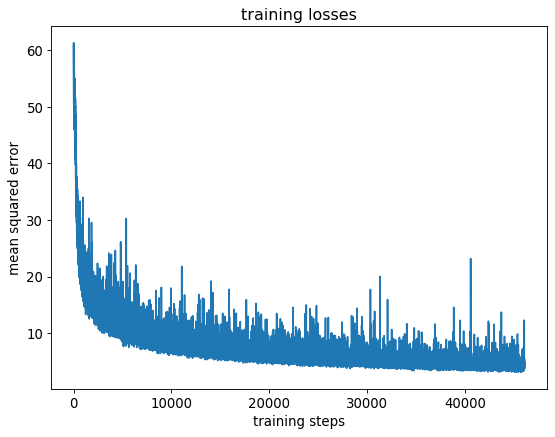

In [34]:
plt.plot(trn_losses)
# plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
# plt.legend(["trn", "val"])
plt.show()

In [27]:
x_prd, y_prd = data_generator(nsamples=512, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

In [28]:
err = []
for ix, item_prd in enumerate(prd_dataset):
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2 = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))

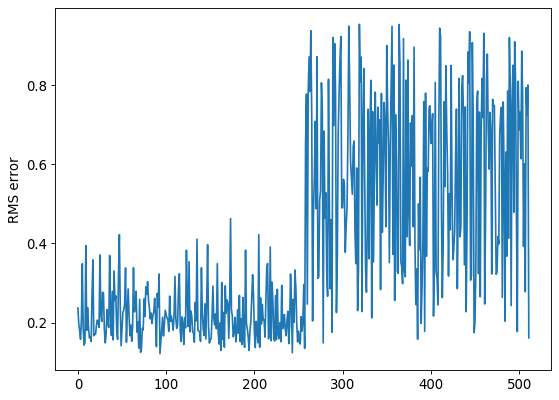

Mean Error on Validation Set: 0.3950


In [29]:
plt.plot(np.arange(len(prd_dataset)), err)
plt.ylabel("RMS error")
plt.show()

print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

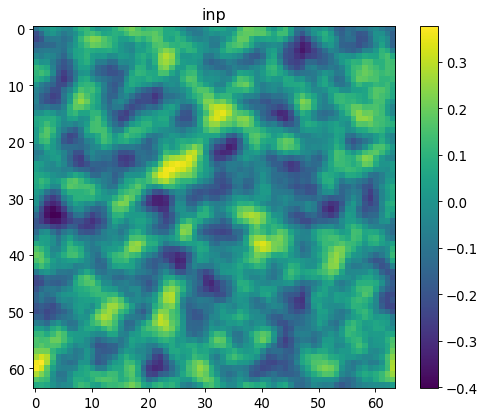

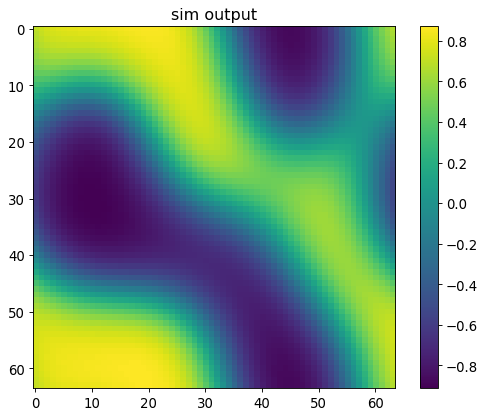

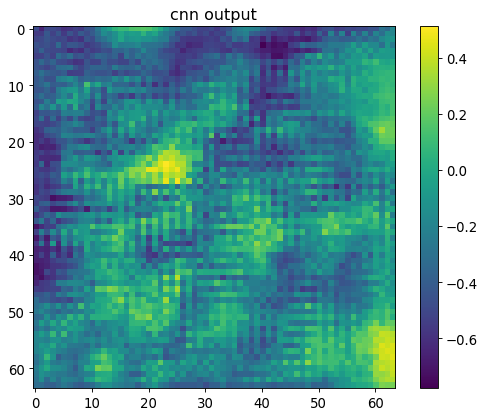

tensor(0.3976, device='cuda:0', dtype=torch.float64)


In [33]:
ix = 24

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
model.eval()
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

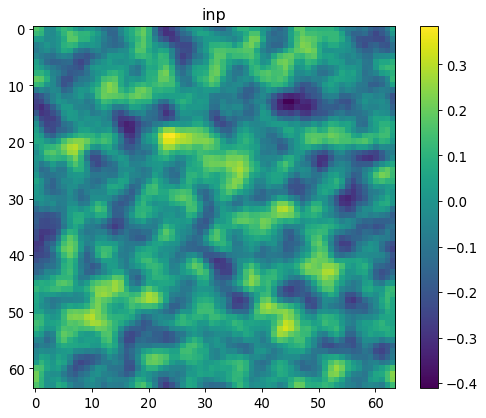

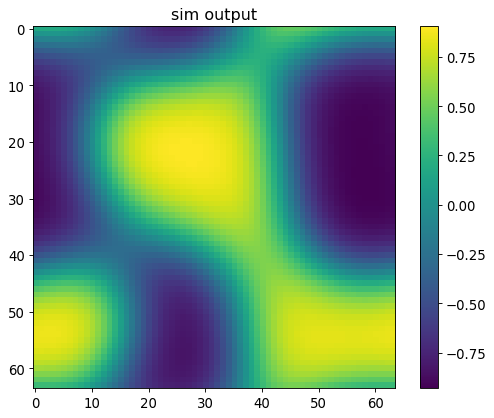

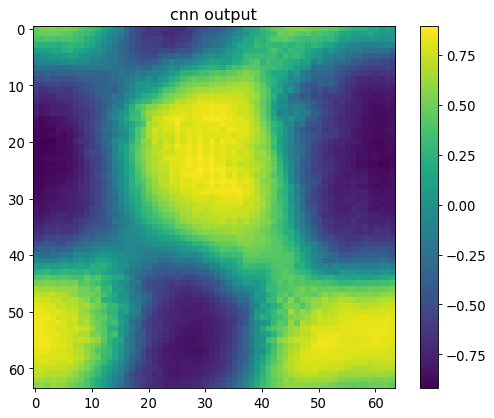

tensor(0.0355, device='cuda:0', dtype=torch.float64)


In [32]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

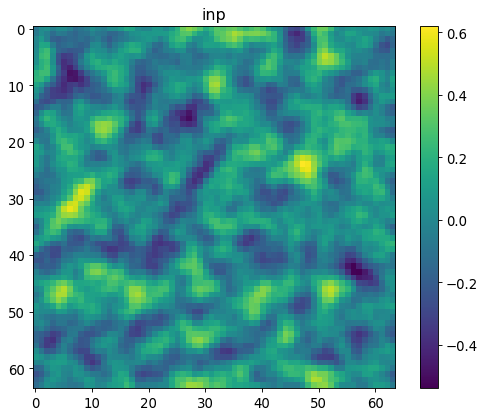

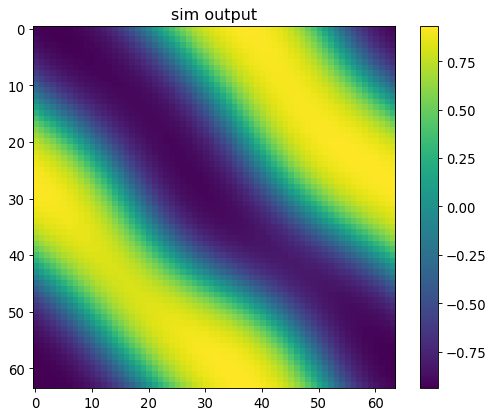

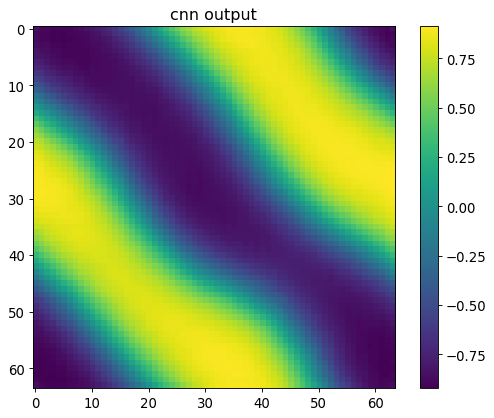

tensor(0.0017, device='cuda:0', dtype=torch.float64)


In [51]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

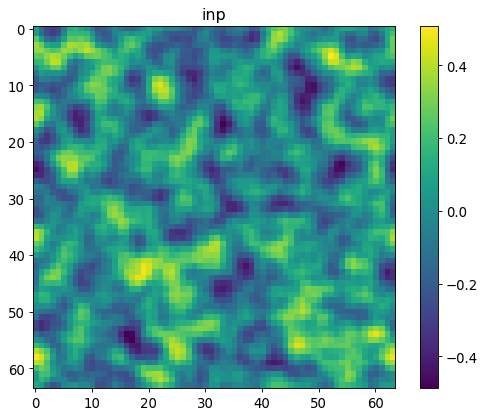

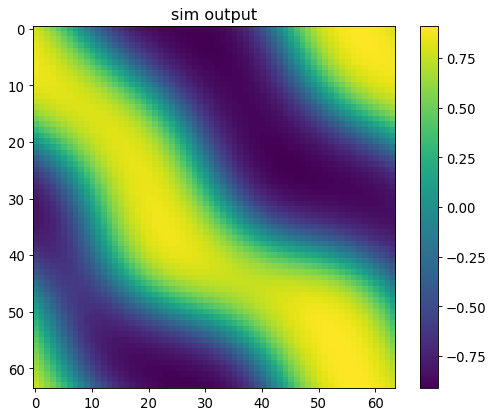

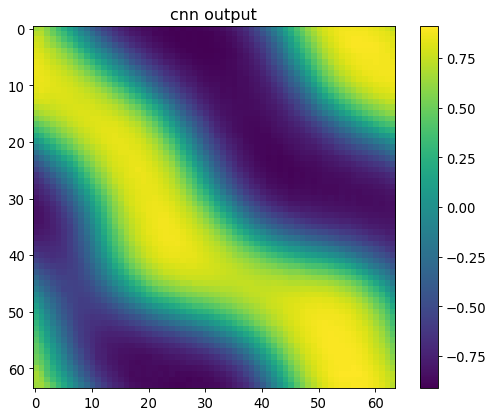

tensor(0.0020, device='cuda:0', dtype=torch.float64)


In [52]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)